In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import scipy.sparse as sp
import math

from kuramoto import *
from wilson_cowan import *

import networkx as nx

from itertools import product

import pickle

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

# Determining Parameters

Find a parameter regime that admits oscillations and is sensitive to adding random connections.

In [119]:
N = 50
radius = 3
wcn, edge_list = nazemi_jamali_network(N, neighbor_radius=radius, random_edges=20)

θE = -2
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

wcn.excitatory_variance = .05
wcn.inhibitory_variance = 0

In [120]:
t_final = 50
time_span = (t_final/2, t_final)
ts, Es, Is = wcn.simulate(t_final, Δt = 1e-3)
kuramoto = kuramoto_measure(ts, Es.T)
print(f'Kuramoto: {average_kuramoto(ts, Es.T, time_span=time_span, kuramoto=kuramoto)}')
print(f'Pearson: {pearson_mean(ts, Es, time_span=time_span)}')

Kuramoto: 0.6132561768746533
Pearson: 0.3064134018946484


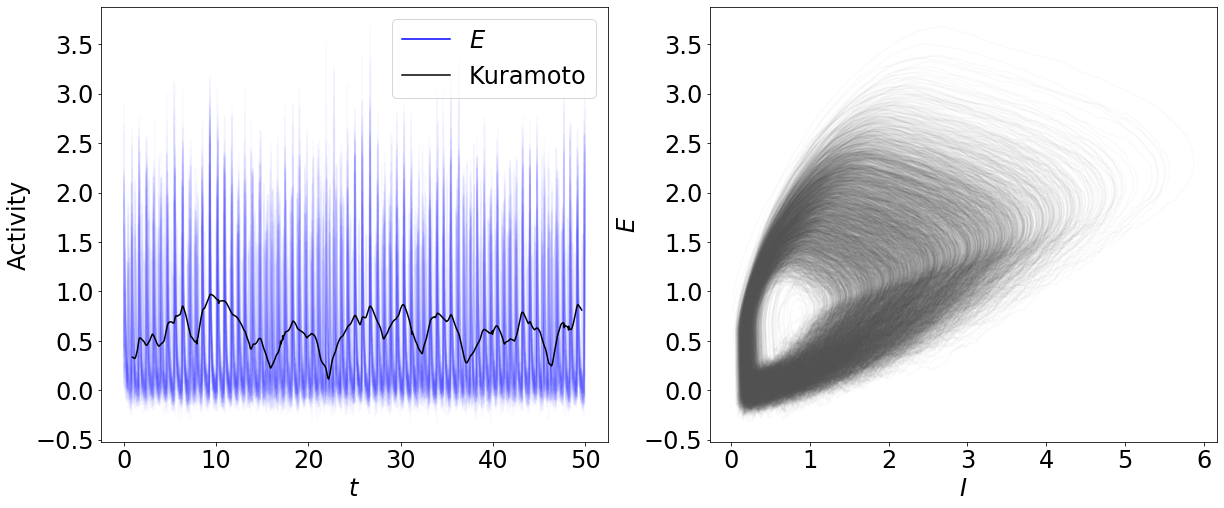

In [121]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/N)
plt.plot([], [], 'b-', label='$E$')
# plt.plot(ts, Is, 'm-', alpha=1/N)
# plt.plot([], [], 'm-', label='$I$')
plt.plot(ts, kuramoto, 'k-', label='Kuramoto')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/N)
plt.xlabel('$I$')
plt.ylabel('$E$')

plt.show()

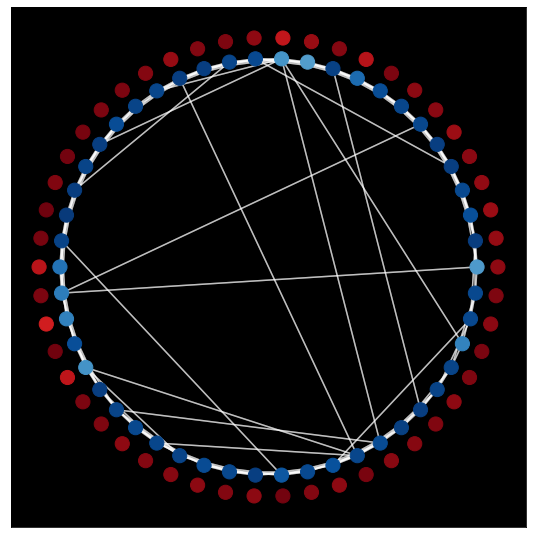

In [122]:
time_index = 6950

angles = np.linspace(0, 2*np.pi, N, endpoint=False)
xs = np.cos(angles)
ys = np.sin(angles)

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot(np.cos([angles[node] for node in edge]), np.sin([angles[node] for node in edge]), 'w-', zorder=0, alpha=0.5)

size = 200
shrink_factor = 1.1
scatter_plot_excitatory = ax.scatter(xs, ys, s=size, c=Es[time_index], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')
scatter_plot_inhibibory = ax.scatter(xs*shrink_factor, ys*shrink_factor, s=size, c=Is[time_index], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')

plt.tight_layout()
plt.show()

0.4089121887287025 2.819591836734694 5


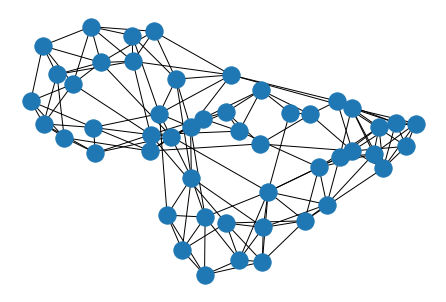

In [157]:
G = nx.convert.from_edgelist(edge_list)
nx.draw(G)
clustering_coeff = nx.transitivity(G)
mean_path_length = nx.average_shortest_path_length(G)
diameter = nx.networkx.algorithms.distance_measures.diameter(G)
print(clustering_coeff, mean_path_length, diameter)

In [158]:
def get_network_statistics(edge_list):
    G = nx.convert.from_edgelist(edge_list)
    clustering_coeff = nx.transitivity(G)
    mean_path_length = nx.average_shortest_path_length(G)
    diameter = nx.networkx.algorithms.distance_measures.diameter(G)
    return clustering_coeff, mean_path_length, diameter

In [160]:
kuramoto = average_kuramoto(ts, Es.T, time_span=time_span)
pearson = pearson_mean(ts, Es, time_span=time_span)
clustering_coefficient, mean_path_length, daimeter = get_network_statistics(edge_list)

print(kuramoto, pearson, clustering_coefficient, mean_path_length, diameter)

0.6132561768746533 0.3064134018946484 0.4089121887287025 2.819591836734694 5


# Setup and Run Experiments

In [9]:
def get_network_statistics(edge_list):
    G = nx.convert.from_edgelist(edge_list)
    clustering_coeff = nx.transitivity(G)
    mean_path_length = nx.average_shortest_path_length(G)
    diameter = nx.networkx.algorithms.distance_measures.diameter(G)
    return clustering_coeff, mean_path_length, diameter

def initialize_model(N, neighbor_radius, random_edges, variance):
    wcn, edge_list = nazemi_jamali_network(N, neighbor_radius=radius, random_edges=random_edges)

    θE = -2
    θI = 8
    wcn.excitatory_firing_rate = lambda x: relu(x - θE)
    wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

    wcn.excitatory_variance = variance
    wcn.inhibitory_variance = 0
    
    return wcn, edge_list

In [55]:
Ns = [10, 20, 50, 100, 200]
radii = [1, 2, 4, 6, 10]
random_edges_list = [0, 5, 10, 20, 50, 100, 'max']
variances = [0, 0.005, 0.01, 0.05, 0.10]
trials = 10

t_final = 10
time_span = (t_final/2, t_final)

num_experiments = len(list(product(Ns, radii, random_edges_list, variances, range(trials))))
results_key = [
    'experiment_index', 
    'trial',
    'N', 
    'radius', 
    'random_edges', 
    'variance', 
    'trial',
    'kuramoto',
    'pearson',
    'clustering_coefficient',
    'mean_path_length',
    'diameter'
]
print(num_experiments)

8750


In [43]:
results = []
errors_list = []
for experiment_index, (N, radius, random_edges, variance, trial) in enumerate(product(Ns, radii, random_edges_list, variances, range(trials))):
    print(f'{experiment_index+1}/{num_experiments}' + ' '*100, end='\r')
    m = radius*N
    if random_edges is 'max':
        random_edges = m
    elif random_edges >= m:
        errors_list.append(experiment_index)
        continue #skip if too many random edges
    try:
        wcn, edge_list = initialize_model(N, radius, random_edges, variance)
        ts, Es, Is = wcn.simulate(t_final, Δt = 1e-3)
        kuramoto = average_kuramoto(ts, Es.T, time_span=time_span)
        pearson = pearson_mean(ts, Es, time_span=time_span)
        clustering_coefficient, mean_path_length, diameter = get_network_statistics(edge_list)
        result = (
            experiment_index, 
            trial,
            N, 
            radius, 
            random_edges, 
            variance, 
            trial,
            kuramoto,
            pearson,
            clustering_coefficient,
            mean_path_length,
            diameter
        )

        results.append(result)
        with open(f'raw_data/experiment01/index{experiment_index}.pickle', 'wb') as f:
            pickle.dump(result, f)
    except:
        errors_list.append(experiment_index)
with open(f'raw_data/experiment01/errors.pickle', 'wb') as f:
    pickle.dump(errors_list, f)
print('complete' + ' '*100)

complete                                                                                                    


### Load experiments

In [44]:
# results = []
# with open(f'raw_data/experiment01/errors.pickle', 'rb') as f:
#     errors_list = pickle.load(f)
    
# print(errors_list)

# for experiment_index in range(num_experiments):
#     if experiment_index in errors_list:
#         continue
#     with open(f'raw_data/experiment01/index{experiment_index}.pickle', 'rb') as f:
#         result = pickle.load(f)
#         results.append(result)
        
# print('results loaded')

[4, 5, 6, 29, 30, 31, 32, 34, 35]
results loaded


### Mean Path Length vs Synchrony

In [45]:
kuramoto_index = results_key.index('kuramoto')
kuramoto_list = [result[kuramoto_index] for result in results]

pearson_index = results_key.index('pearson')
pearson_list = [result[pearson_index] for result in results]

mean_path_index = results_key.index('mean_path_length')
mean_path_list = [result[mean_path_index] for result in results]

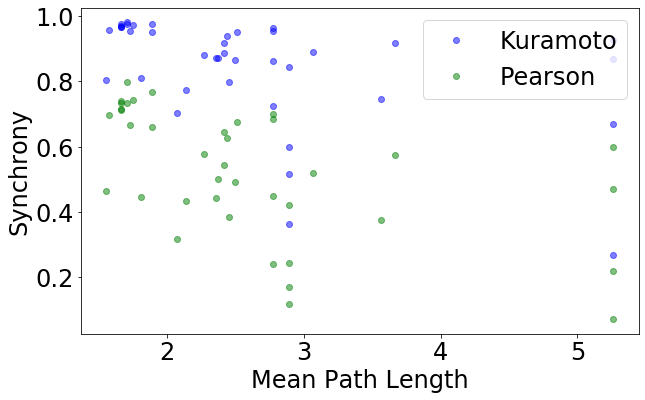

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(mean_path_list, kuramoto_list, 'bo', label='Kuramoto', alpha = .5)
plt.plot(mean_path_list, pearson_list, 'go', label='Pearson', alpha = .5)
plt.xlabel('Mean Path Length')
plt.ylabel('Synchrony')
plt.legend()
plt.show()

### Diameter vs Synchrony

In [49]:
kuramoto_index = results_key.index('kuramoto')
kuramoto_list = [result[kuramoto_index] for result in results]

pearson_index = results_key.index('pearson')
pearson_list = [result[pearson_index] for result in results]

diameter_index = results_key.index('diameter')
diameter_list = [result[diameter_index] for result in results]

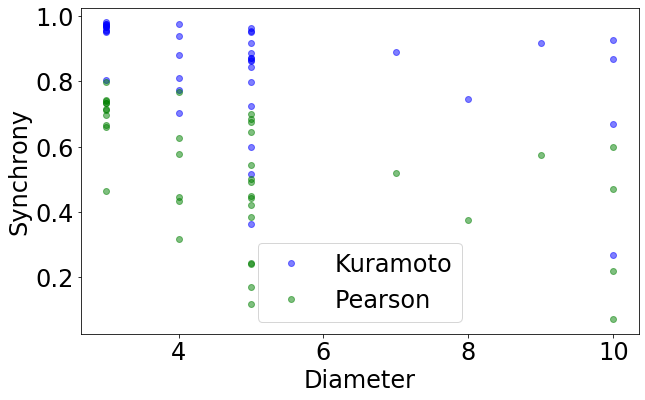

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(diameter_list, kuramoto_list, 'bo', label='Kuramoto', alpha = .5)
plt.plot(diameter_list, pearson_list, 'go', label='Pearson', alpha = .5)
plt.xlabel('Diameter')
plt.ylabel('Synchrony')
plt.legend()
plt.show()

### Clustering Coefficient vs Synchrony

In [53]:
kuramoto_index = results_key.index('kuramoto')
kuramoto_list = [result[kuramoto_index] for result in results]

pearson_index = results_key.index('pearson')
pearson_list = [result[pearson_index] for result in results]

clustering_coefficient_index = results_key.index('clustering_coefficient')
clustering_coefficient_list = [result[clustering_coefficient_index] for result in results]

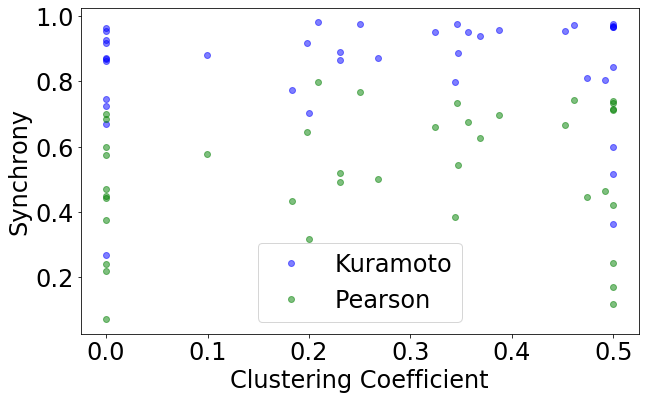

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(clustering_coefficient_list, kuramoto_list, 'bo', label='Kuramoto', alpha = .5)
plt.plot(clustering_coefficient_list, pearson_list, 'go', label='Pearson', alpha = .5)
plt.xlabel('Clustering Coefficient')
plt.ylabel('Synchrony')
plt.legend()
plt.show()